In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
TARGET = 'PJME_MW'

In [3]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


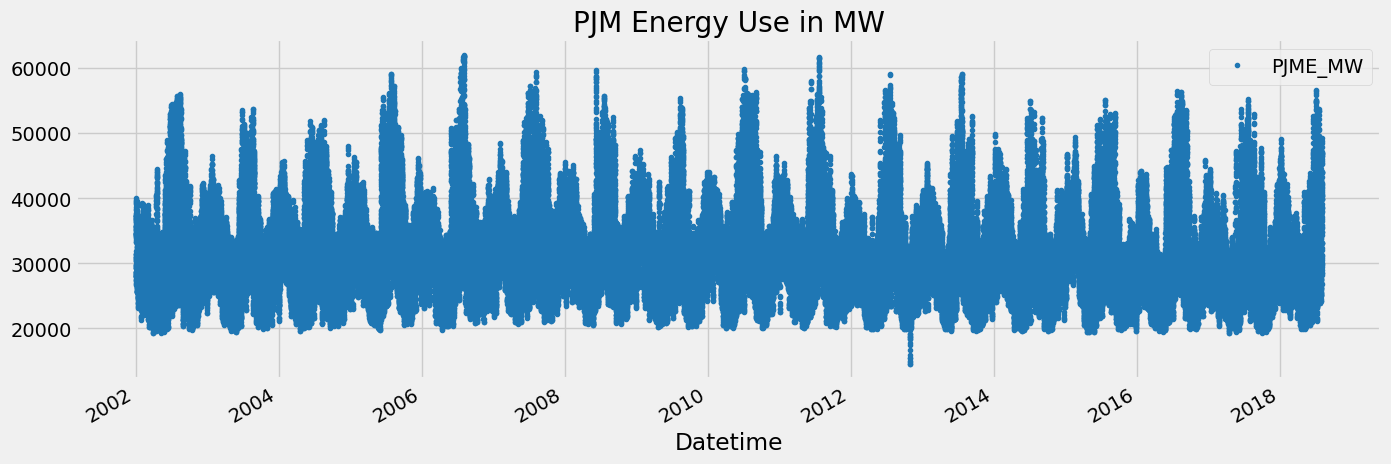

In [4]:
df.plot(style='.',
        figsize = (15,5),
        color = color_pal[0],
        title='PJM Energy Use in MW')
plt.show()

## Remove outlier

**We can see the value less than 20000 is outlier value**

<AxesSubplot: ylabel='Frequency'>

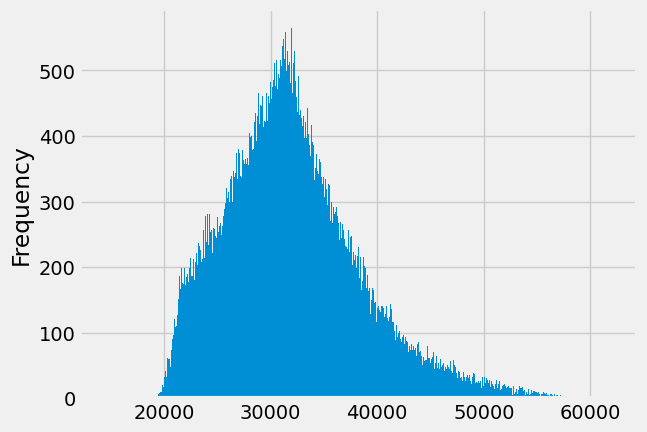

In [5]:
df[TARGET].plot(kind = 'hist',bins = 1000)

<AxesSubplot: xlabel='Datetime'>

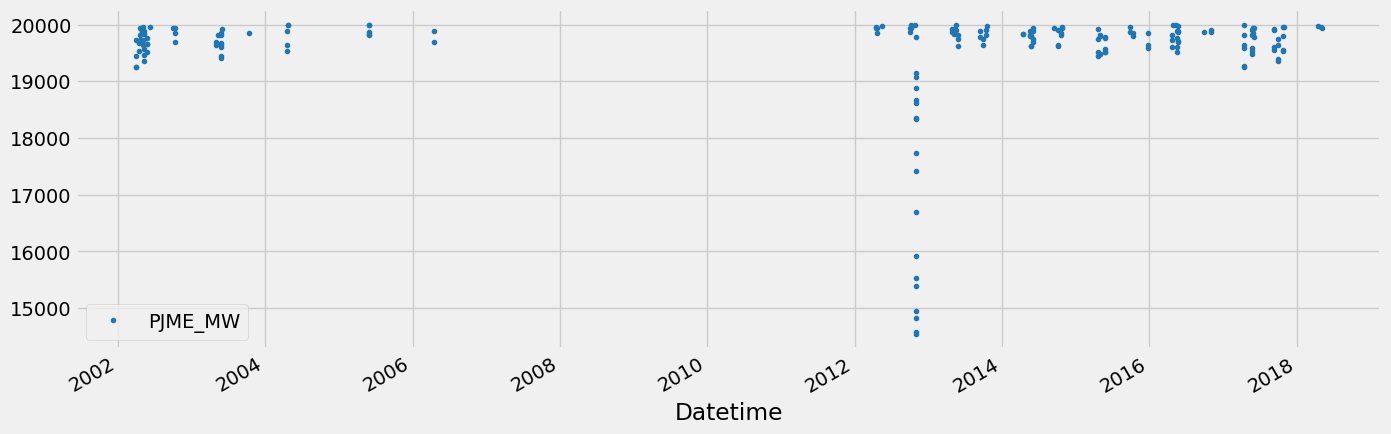

In [6]:
df.query('PJME_MW < 20000').plot(style='.',color = color_pal[0],figsize = (15,5))

**We can set threshold value less than 20000**

<AxesSubplot: xlabel='Datetime'>

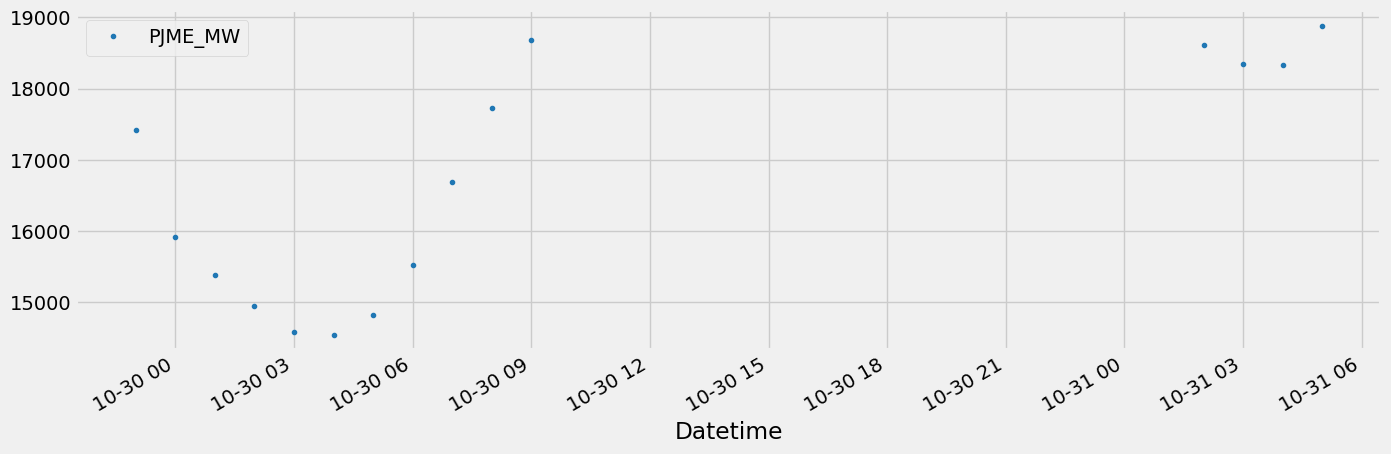

In [7]:
THRESHOLD = 19000
df.query(f'PJME_MW < {THRESHOLD}').plot(style='.',color = color_pal[0],figsize = (15,5))

In [8]:
## Remove ouliers
df = df.query(f'PJME_MW > {THRESHOLD}')
len(df.query(f'PJME_MW < {THRESHOLD}'))

0

## Create features

In [9]:
def create_features(df:pd.DataFrame):
    '''
        Create more features from the original dataset base on time series index
    '''
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.weekofyear
    return df
def add_lags(df,TARGET):
    target_map = df[TARGET].to_dict()
    # We choose 364 because 364/7 = 52 =>  exactly 52 weeks
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta(f'{2*364} days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta(f'{3*364} days')).map(target_map)
    df['lag4'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    return df
df  = create_features(df)
df = add_lags(df,TARGET)

In [10]:
df.sample(10)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,lag4
Datetime,,,,,,,,,,,,,
2012-06-12 16:00:00,36392.0,16,1,2,6,2012,164,12,24,34872.0,41422.0,34613.0,28578.0
2012-12-08 19:00:00,32460.0,19,5,4,12,2012,343,8,49,35506.0,36414.0,37714.0,35233.0
2014-05-07 15:00:00,29103.0,15,2,2,5,2014,127,7,19,30530.0,31909.0,31858.0,32485.0
2011-01-28 04:00:00,30063.0,4,4,1,1,2011,28,28,4,32806.0,31834.0,29442.0,29406.0
2003-02-12 15:00:00,36476.0,15,2,1,2,2003,43,12,7,32510.0,NaN,NaN,35205.0
2013-02-06 10:00:00,36698.0,10,2,1,2,2013,37,6,6,35330.0,40707.0,37055.0,34267.0
2008-03-28 10:00:00,33413.0,10,4,1,3,2008,88,28,13,33150.0,31461.0,32046.0,36487.0
2016-07-28 22:00:00,41700.0,22,3,3,7,2016,210,28,30,42768.0,38005.0,36063.0,37793.0
2010-01-06 19:00:00,42612.0,19,2,1,1,2010,6,6,1,40255.0,36226.0,41378.0,40120.0


## Train Test Split

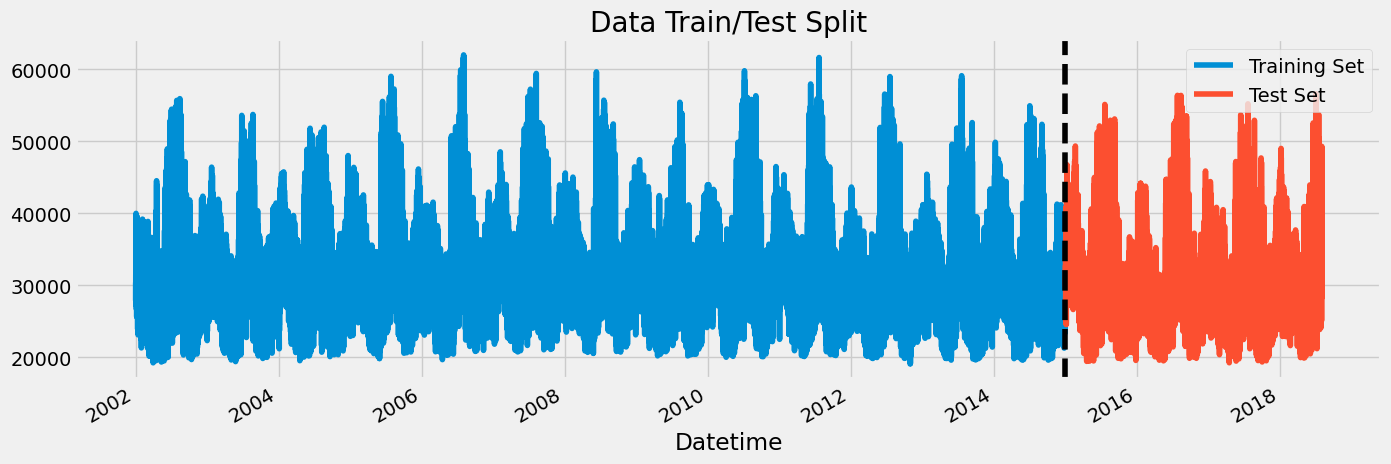

In [11]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train[TARGET].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test[TARGET].plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Cross Validation

In [12]:
from sklearn.model_selection import TimeSeriesSplit
# set up the time series cross validation in 5 folds with 1 year gap between train and test sets
tss = TimeSeriesSplit(n_splits=5,test_size=24*365*1,gap = 24)
df= df.sort_index()

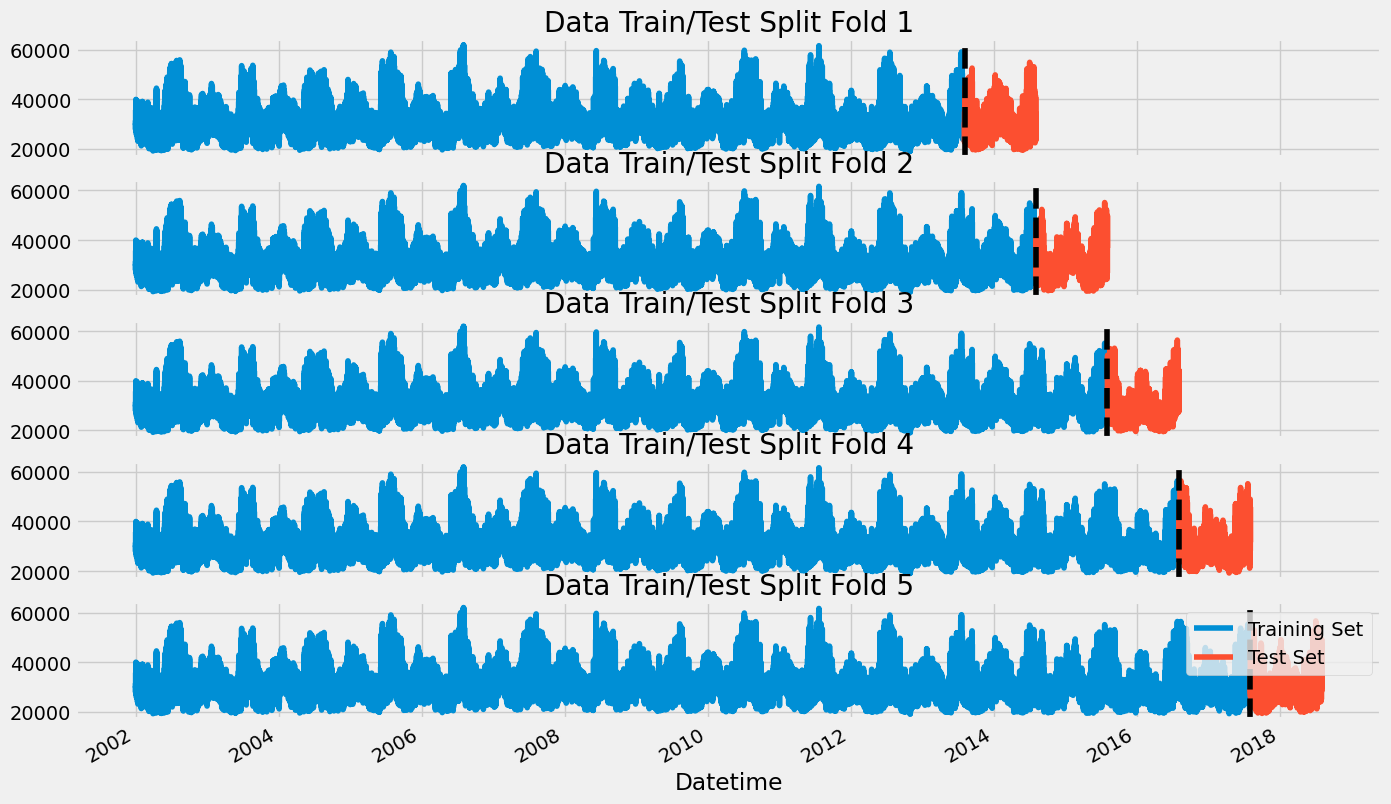

In [13]:
fig,axs = plt.subplots(5,1,figsize = (15,10),sharex=True)

# Visualize the data split in each fold
for fold,(train_idx,val_idx) in enumerate(tss.split(df)):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train[TARGET].plot(ax = axs[fold],title = f'Data Train/Test Split Fold {fold+1}',label = 'Training Set')
    test[TARGET].plot(ax = axs[fold],label = 'Test Set')
    axs[fold].axvline(test.index.min(),color = 'black',linestyle = '--')
plt.legend()
plt.show()

## Training Using Cross Validation

In [14]:
tss = TimeSeriesSplit(n_splits=5,test_size=24*365*1,gap = 24)
df = df.sort_index()

preds = []
scores = []

for fold,(train_idx,val_idx) in enumerate(tss.split(df)):
    # Get train and test sets
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    # Feature Selection
    X_train = train.drop(TARGET,axis = 1)
    y_train = train[TARGET]
    X_test = test.drop(TARGET,axis = 1)
    y_test = test[TARGET]
    # Train model
    model = xgb.XGBRegressor(n_estimators = 1000,
                             booster = 'gbtree',
                             early_stopping_rounds = 50,
                             objective = 'reg:squarederror',
                             max_depth = 5,
                             learning_rate = 0.01)
    model.fit(X_train,y_train,
              eval_set = [(X_train,y_train),(X_test,y_test)],
              verbose = 100)
    y_pred = model.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    print(f'Fold {fold+1} - RMSE: {score}')

[0]	validation_0-rmse:32731.66827	validation_1-rmse:31956.34865
[100]	validation_0-rmse:12441.44438	validation_1-rmse:11939.41907
[200]	validation_0-rmse:5489.99154	validation_1-rmse:5450.09606
[300]	validation_0-rmse:3522.11610	validation_1-rmse:3975.00223
[400]	validation_0-rmse:3064.71860	validation_1-rmse:3783.66875
[479]	validation_0-rmse:2935.75842	validation_1-rmse:3792.66700
Fold 1 - RMSE: 3781.8540270057815
[0]	validation_0-rmse:32671.35140	validation_1-rmse:32141.02994
[100]	validation_0-rmse:12428.78366	validation_1-rmse:12356.19831
[200]	validation_0-rmse:5512.03573	validation_1-rmse:5757.70339
[300]	validation_0-rmse:3556.20547	validation_1-rmse:3875.45520
[400]	validation_0-rmse:3119.27559	validation_1-rmse:3500.52613
[500]	validation_0-rmse:2973.14697	validation_1-rmse:3387.45940
[600]	validation_0-rmse:2882.00153	validation_1-rmse:3342.16872
[700]	validation_0-rmse:2820.59557	validation_1-rmse:3326.79470
[771]	validation_0-rmse:2778.05542	validation_1-rmse:3329.25985
Fo

In [17]:
scores

[3781.8540270057815,
 3325.382880718342,
 3487.272242755494,
 3957.4761822492446,
 3961.374647559791]

In [18]:
print("AVG score: ",np.mean(scores))
print("Best score fold: ",np.argmin(scores))

AVG score:  3702.6719960577307
Best score fold:  1


## Predict in the future

In [23]:
df.sample(10)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,lag4
Datetime,,,,,,,,,,,,,
2008-01-18 17:00:00,34663.0,17,4,1,1,2008,18,18,3,36245.0,32243.0,39685.0,39276.0
2008-01-30 06:00:00,29706.0,6,2,1,1,2008,30,30,5,35059.0,29808.0,35479.0,28697.0
2006-01-04 14:00:00,35049.0,14,2,1,1,2006,4,4,1,35271.0,38882.0,34580.0,37147.0
2013-04-09 14:00:00,31083.0,14,1,2,4,2013,99,9,15,29572.0,30780.0,31150.0,26689.0
2013-07-17 11:00:00,49613.0,11,2,3,7,2013,198,17,29,52340.0,47216.0,47376.0,38504.0
2013-08-30 07:00:00,30672.0,7,4,3,8,2013,242,30,35,29829.0,29154.0,35088.0,28094.0
2011-09-26 05:00:00,25128.0,5,0,3,9,2011,269,26,39,23479.0,21756.0,23561.0,28237.0
2008-02-09 17:00:00,31337.0,17,5,1,2,2008,40,9,6,35225.0,34673.0,31654.0,35134.0
2013-11-11 00:00:00,25399.0,0,0,4,11,2013,315,11,46,23988.0,24575.0,24820.0,24707.0


In [26]:
# Retrain all the model
X_all = df.drop(TARGET,axis = 1)
y_all = df[TARGET]

model = xgb.XGBRegressor(n_estimators = 1000,
                             booster = 'gbtree',
                             early_stopping_rounds = 50,
                             objective = 'reg:squarederror',
                             max_depth = 5,
                             learning_rate = 0.01)
model.fit(X_all,y_all,
          eval_set=[(X_all,y_all)],
          verbose = 100)

[0]	validation_0-rmse:32403.06372
[100]	validation_0-rmse:12347.44515
[200]	validation_0-rmse:5537.61026
[300]	validation_0-rmse:3651.91852
[400]	validation_0-rmse:3241.69495
[500]	validation_0-rmse:3105.45979
[600]	validation_0-rmse:3023.14301
[700]	validation_0-rmse:2954.73130
[800]	validation_0-rmse:2897.37743
[900]	validation_0-rmse:2849.39365
[999]	validation_0-rmse:2808.59964


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [27]:
np.max(df.index)

Timestamp('2018-08-03 00:00:00')

In [34]:
# Create future data
future = pd.date_range('2018-08-03','2019-08-1',freq='1h')
future_df = pd.DataFrame(index= future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df,future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future,TARGET)

## Predict in the future

In [39]:
future_df['pred'] = model.predict(df_and_future.query('isFuture').drop([TARGET,'isFuture'],axis = 1))

<AxesSubplot: title={'center': "Prediction from '2018-08-03' to '2019-08-1'"}>

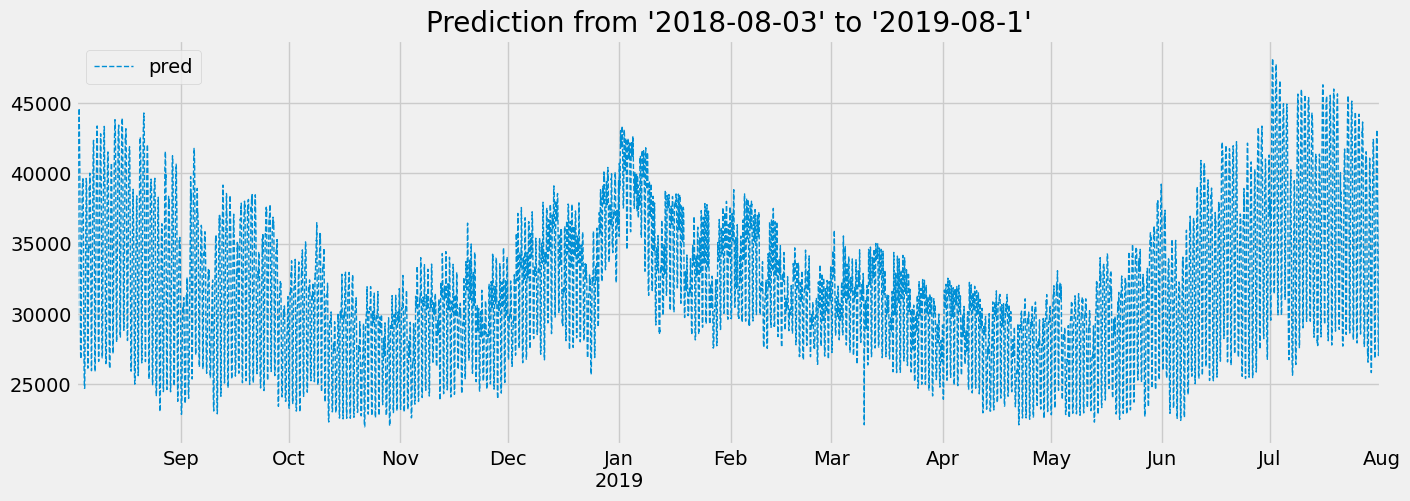

In [44]:
future_df.plot(figsize=(15,5),style='--',lw = 1,ms = 1,title="Prediction from '2018-08-03' to '2019-08-1'")

## Save model

In [45]:
model.save_model('model.json')

<AxesSubplot: title={'center': "Prediction from '2018-08-03' to '2019-08-1'"}>

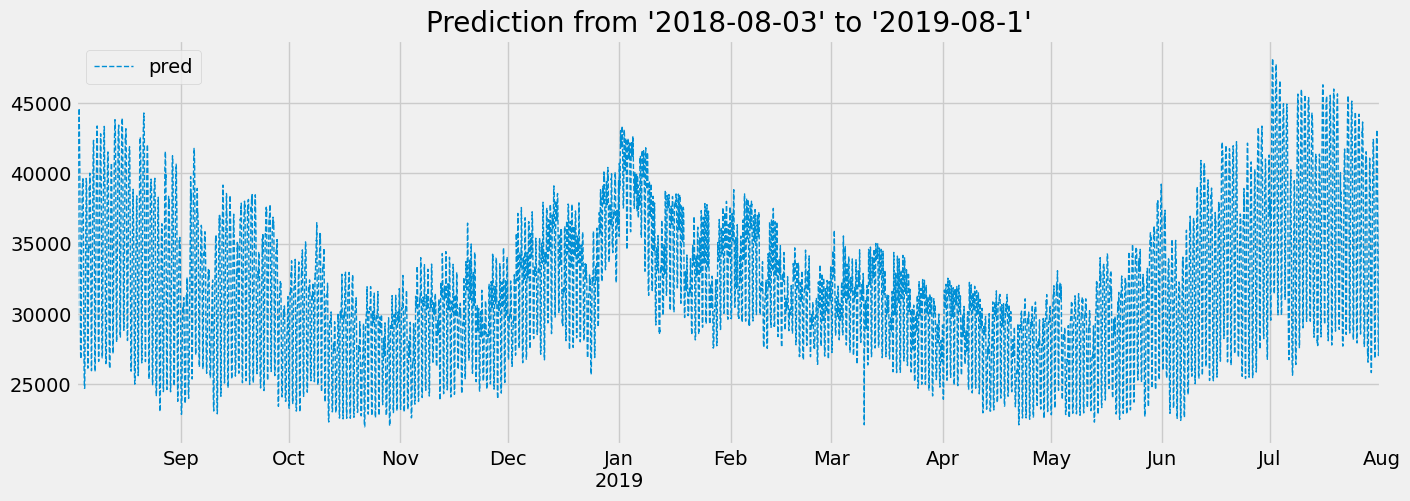

In [50]:
model.load_model('model.json')
future_df['pred'] = model.predict(df_and_future.query('isFuture').drop([TARGET,'isFuture'],axis = 1))
future_df.plot(figsize=(15,5),style='--',lw = 1,ms = 1,title="Prediction from '2018-08-03' to '2019-08-1'")